## 0. Getting Setup

In [1]:
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

In [3]:
import os
import zipfile
from pathlib import Path
import requests

# Setup the folder path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory exists")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents = True, exist_ok = True)

  # Download pizza, steak, sushsi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  # Unzip pizza, steak and sushi
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

  # Remove the zip file
  os.remove(data_path / "pizza_steak_sushi")

data/pizza_steak_sushi directory exists


### 1.1 Setting up Train and Test Dir's

In [4]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

### 2.1 Create a transforms pipeline manually (required for torchvision < 0.13)


In [5]:
from torchvision import transforms

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])
])

In [6]:
from torchvision import datasets

# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(train_dir, transform = manual_transforms)
test_data = datasets.ImageFolder(test_dir, transform = manual_transforms)

In [7]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_data,
    batch_size = 32,
    shuffle = True,
    num_workers = 4,
    pin_memory = True
)

test_dataloader = DataLoader(
    test_data,
    batch_size = 32,
    shuffle = False,
    num_workers = 4,
    pin_memory = True
)

train_dataloader, test_dataloader, train_data.classes

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(<torch.utils.data.dataloader.DataLoader at 0x7bdcfe197d90>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for torchvision.models (auto creation)¶

In [9]:
import torchvision

# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [10]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [11]:
train_data = datasets.ImageFolder(train_dir, transform = auto_transforms)
test_data = datasets.ImageFolder(test_dir, transform = auto_transforms)

In [12]:
train_dataloader = DataLoader(
    train_data,
    batch_size = 32,
    shuffle = True,
    num_workers = 4,
    pin_memory = True
)

test_dataloader = DataLoader(
    test_data,
    batch_size = 32,
    shuffle = False,
    num_workers = 4,
    pin_memory = True
)

train_dataloader, test_dataloader, train_data.classes

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(<torch.utils.data.dataloader.DataLoader at 0x7bdcf58d6d40>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

Since we're working on a computer vision problem (image classification with FoodVision Mini), we can find pretrained classification models in torchvision.models.

### 3.1 Which pretrained model should you use?

It depends on your problem/the device you're working with.

Generally, the higher number in the model name (e.g. efficientnet_b0() -> efficientnet_b1() -> efficientnet_b7()) means better performance but a larger model.

You might think better performance is always better, right?

That's true but some better performing models are too big for some devices.

For example, say you'd like to run your model on a mobile-device, you'll have to take into account the limited compute resources on the device, thus you'd be looking for a smaller model.

### 3.2 Setting up a pretrained model

The pretrained model we're going to be using is `torchvision.models.efficientnet_b0()`.

Our `efficientnet_b0` comes in three main parts:

1. `features` - A collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation/collection of layers is often referred to as features or feature extractor, "the base layers of the model learn the different features of images").
2. `avgpool` - Takes the average of the output of the `features` layer(s) and turns it into a feature vector.
3. `classifier` - Turns the feature vector into a vector with the same dimensionality as the number of required output classes (since `efficientnet_b0` is pretrained on ImageNet and because ImageNet has 1000 classes, `out_features=1000` is the default).


In [18]:
# # OLD: Setup with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# # model = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# # New: Setup the model with pretrained weights and send it to the target device. (torchvision v0.13+)
# weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
# model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# model

# Buggy code

In [19]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
weights = efficientnet_b0(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 75.3MB/s]


In [21]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
# model Uncomment to see a very long output

### 3.3 Getting a summary of our model with torchinfo.summary()

To learn more about our model, let's use torchinfo's summary() method.

To do so, we'll pass in:

* `model` - the model we'd like to get a summary of.
* `input_size` - the shape of the data we'd like to pass to our model, for the case of efficientnet_b0, the input size is (batch_size, 3, 224, 224), though other variants of efficientnet_bX have different input sizes.
* `Note`: Many modern models can handle input images of varying sizes thanks to torch.nn.AdaptiveAvgPool2d(), this layer adaptively adjusts the output_size of a given input as required. You can try this out by passing different size input images to summary() or your models.
* `col_names` - the various information columns we'd like to see about our model.
* `col_width` - how wide the columns should be for the summary.
* `row_settings` - what features to show in a row.

In [29]:
# Print a summary of the model using torchinfo
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

## 3.4 Freezing the base model and changing the output layer to suit our needs

Let's freeze all of the layers/parameters in the features section of our efficientnet_b0 model.

* Note: To freeze layers means to keep them how they are during training. For example, if your model has pretrained layers, to freeze them would be to say, "don't change any of the patterns in these layers during training, keep them how they are." In essence, we'd like to keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.

In [30]:
for param in model.features.parameters():
  param.requires_grad = False

Let's now adjust the output layer or the `classifier` portion of our pretrained model to our needs.

Right now our pretrained model has `out_features=1000` because there are 1000 classes in ImageNet.

However, we don't have 1000 classes, we only have three, pizza, steak and sushi.

We can change the `classifier` portion of our model by creating a new series of layers.

We'll keep the `Dropout` layer the same using `torch.nn.Dropout(p=0.2, inplace=True)`.

And we'll keep `in_features=1280` for our Linear output layer but we'll change the `out_features` value to the length of our `class_names` `(len(['pizza', 'steak', 'sushi']) = 3)`.

In [31]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(train_data.classes)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p = 0.2, inplace = True),
    torch.nn.Linear(in_features = 1280,
                    out_features = output_shape,
                    bias = True)).to(device)

In [32]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train model

In [34]:
from torch import nn

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [35]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [36]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [38]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [39]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model = model,
                train_dataloader = train_dataloader,
                test_dataloader = test_dataloader,
                optimizer = optimizer,
                loss_fn = loss_fn,
                epochs = 5,
                device = device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time: .3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total training time:  16.657 seconds


## 5. Evaluate model by plotting loss curves

[INFO] Couldn't find helper_functions.py, downloading...


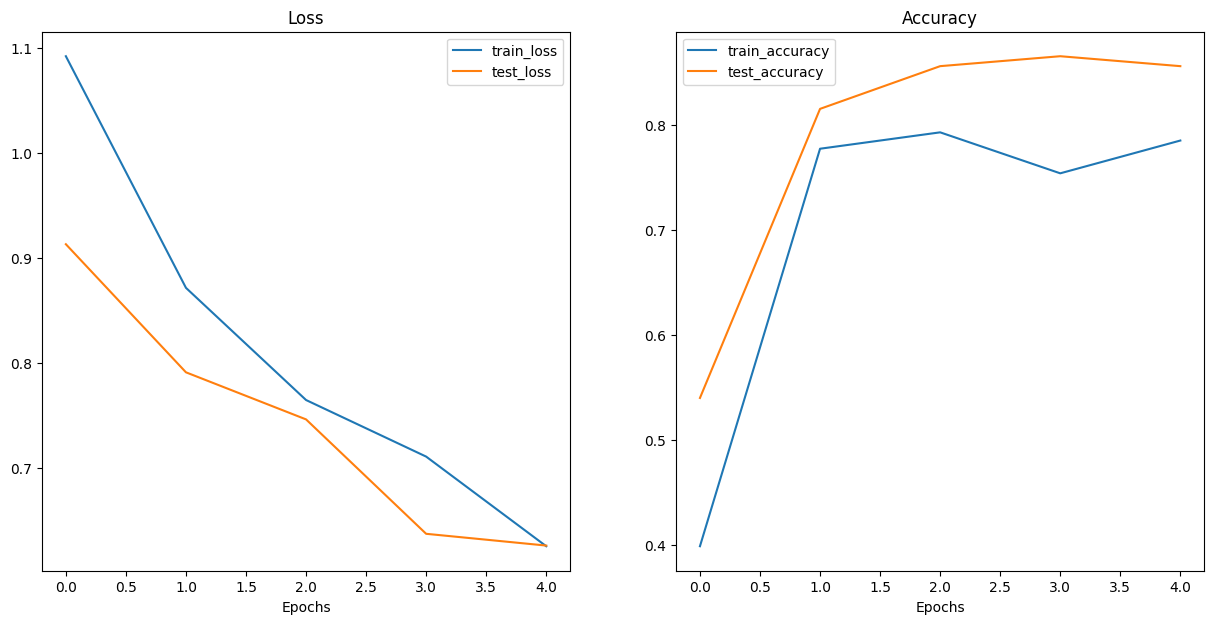

In [40]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## 6. Make predictions on images from the test set

To do all of this, we'll create a function `pred_and_plot_image()` to:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open an image with `PIL.Image.open()`.
3. Create a transform for the image (this will default to the `manual_transforms` we created above or it could use a transform generated from `weights.transforms()`).
4. Make sure the model is on the target device.
5. Turn on model eval mode with `model.eval()` (this turns off layers like `nn.Dropout()`, so they aren't used for inference) and the inference mode context manager.
6. Transform the target image with the transform made in step 3 and add an extra batch dimension with `torch.unsqueeze(dim=0)` so our input image has shape `[batch_size, color_channels, height, width]`.
7. Make a prediction on the image by passing it to the model ensuring it's on the target device.
8. Convert the model's output logits to prediction probabilities with `torch.softmax()`.
9. Convert model's prediction probabilities to prediction labels with `torch.argmax()`.
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8.

In [46]:
from typing import List, Tuple
import matplotlib.pyplot as plt

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device):
  # 2. Open image
  img = Image.open(image_path)

  # 3. Create transformation for the image (if one doesn't exist)
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.506],
                             std = [0.229, 0.224, 0.225]),
    ])

    ### Predict on image ###

    # 4. Make sure te model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim = 0)

      # 7. Make a prediction on image with an extra dimension and send it to the target devcie
      target_image_pred = model(transformed_image.to(device))

      # 8. Convert logits -> perdiction probabilities (using torch.softmax() for multi-class classification)
      target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)

      # 9. Convert prediction probabilities -> prediction labels
      target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)

      # 10. Plot image with predicted label and probability
      plt.figure()
      plt.imshow(img)
      plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max(): .3f}")
      plt.axis(False)

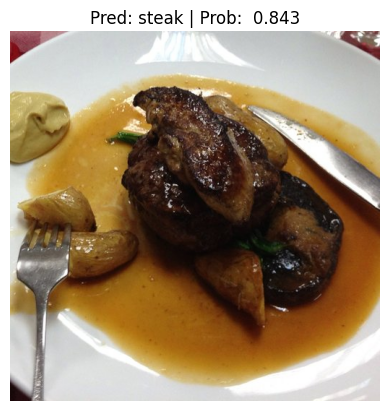

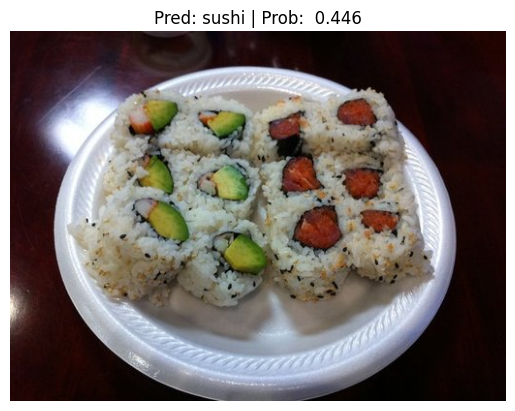

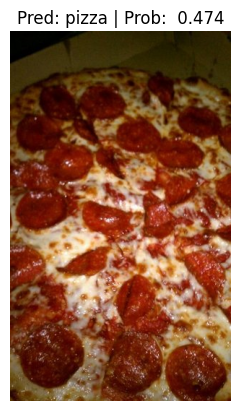

In [47]:
# Get a random list of image paths from the test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population = test_image_path_list, # go through all of the test image paths
                                       k = num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model = model,
                      image_path = image_path,
                      class_names = train_data.classes,
                      image_size = (224, 224))

### 6.1 Making predictions on a custom image

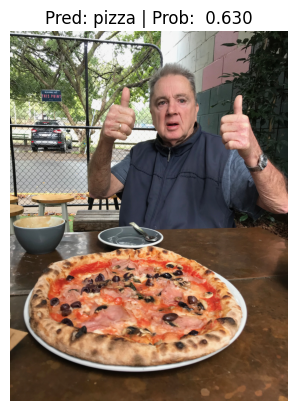

In [48]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=train_data.classes)

## 7. Main Takeaways

* Transfer learning often allows to you get good results with a relatively small amount of custom data.
* Knowing the power of transfer learning, it's a good idea to ask at the start of every problem, "does an existing well-performing model exist for my problem?"
* When using a pretrained model, it's important that your custom data be formatted/preprocessed in the same way that the original model was trained on, otherwise you may get degraded performance.
* The same goes for predicting on custom data, ensure your custom data is in the same format as the data your model was trained on.
* There are several different places to find pretrained models from the PyTorch domain libraries, HuggingFace Hub and libraries such as timm (PyTorch Image Models).